<a href="https://colab.research.google.com/github/shayana-raj/Stock_Price_Prediction/blob/main/Stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install yfinance==0.1.70
!pip install yahoo-fin==0.8.9.1
!pip install mplfinance
!pip install pmdarima
#!pip install fbprophet

In [9]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mpdates
import seaborn as sns
import yfinance as yf

import datetime
from dateutil.parser import parse

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

import math
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

import pmdarima as pm
from pmdarima.arima.utils import ndiffs

#from fbprophet import Prophet
#from prophet.plot import plot_plotly

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

In [13]:
df_amzn = pd.read_csv("/content/AMZN.csv")

In [14]:
print('\t\tStart Date\t\tEnd Date')
print('AMZN\t\t{}\t\t{}'.format(df_amzn['Date'][0], df_amzn.iloc[-1, 0]))
df_amzn['Date'] = df_amzn.Date.apply(parse)

		Start Date		End Date
META		2012-05-18		2022-07-12
AAPL		1980-12-12		2022-07-12
AMZN		1997-05-15		2022-07-12
NFLX		2002-05-23		2022-07-12
GOOG		2004-08-19		2022-07-12


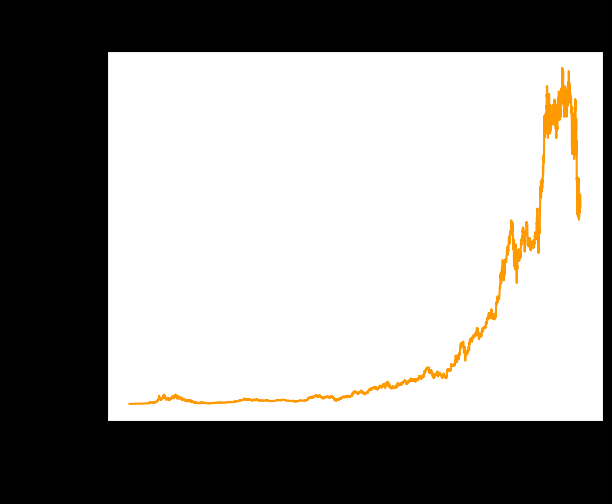

In [23]:
plt.figure().set_facecolor('black')
plt.plot(df_amzn['Date'], df_amzn['Close'], color='#FF9900')
plt.title("Amazon's Stock Price", fontsize=30)
plt.xlabel('Time', fontsize=25)
plt.ylabel('Closing Price', fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [24]:
candlestick_chart_data = ['Date', 'Open', 'High', 'Low', 'Close']
new_amzn_df = df_amzn[candlestick_chart_data]

def create_moving_averages_columns(company_data):
    days_for_moving_averages = [10, 50, 100]

    for moving_averages in days_for_moving_averages:
        column = f'MA for {moving_averages} days'
        company_data[column] = company_data['Close'].rolling(moving_averages).mean()

    return company_data

new_amzn_df = create_moving_averages_columns(new_amzn_df)

new_amzn_df.tail(10)

,Date,Open,High,Low,Close,MA for 10 days,MA for 50 days,MA for 100 days
6321,2022-06-28,113.500000,114.849998,107.040001,107.400002,108.701,119.339671,137.116405
6322,2022-06-29,107.379997,110.989998,106.910004,108.919998,109.362,118.462371,136.817150
6323,2022-06-30,108.110001,108.180000,102.519997,106.209999,109.216,117.424261,136.302855
6324,2022-07-01,106.290001,109.750000,105.849998,109.559998,109.806,116.535501,135.819100
6325,2022-07-05,107.599998,114.080002,106.320000,113.500000,110.534,115.839581,135.339965
6326,2022-07-06,113.209999,115.480003,112.010002,114.330002,111.099,115.239180,134.871370
6327,2022-07-07,113.849998,116.989998,113.489998,116.330002,111.837,114.644300,134.444635
6328,2022-07-08,114.599998,116.580002,113.690002,115.540001,112.147,114.167280,134.067100
6329,2022-07-11,114.080002,114.300003,110.870003,111.750000,111.676,113.638940,133.632930
6330,2022-07-12,112.160004,113.230003,108.339996,109.220001,111.276,112.931410,133.160025


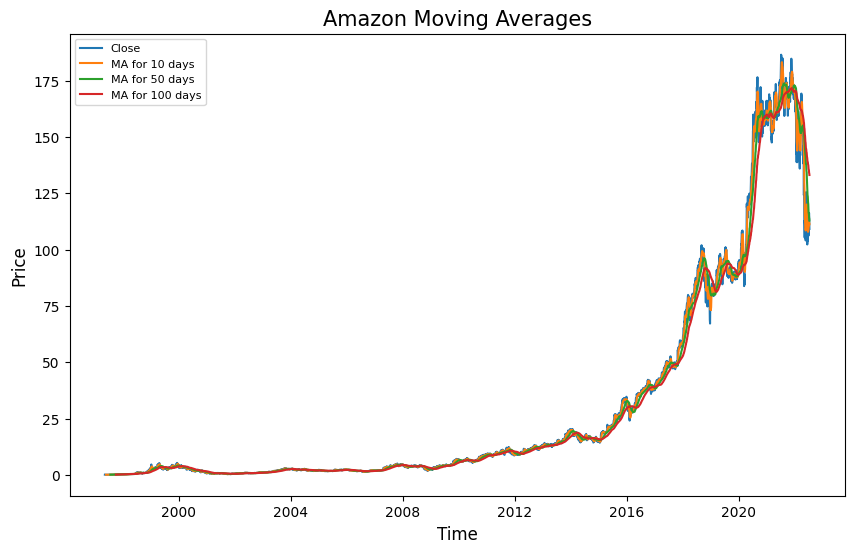

In [27]:
import matplotlib.pyplot as plt

def visualize_moving_averages(company_df, time, feature, ma1, ma2, ma3):
    plt.figure(figsize=(10, 6))
    plt.plot(company_df[time], company_df[feature], label=feature)
    plt.plot(company_df[time], company_df[ma1], label=ma1)
    plt.plot(company_df[time], company_df[ma2], label=ma2)
    plt.plot(company_df[time], company_df[ma3], label=ma3)
    plt.title(f'{company_df.name} Moving Averages', fontsize=15)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Price', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

new_amzn_df.name = 'Amazon'
visualize_moving_averages(new_amzn_df, 'Date', 'Close', 'MA for 10 days', 'MA for 50 days', 'MA for 100 days')


In [28]:
new_amzn_df = df_amzn[candlestick_chart_data]
def adf_test(dataframe, company):
    result = adfuller(dataframe['Close'])
    print('=========For {}========='.format(company))
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
adf_test(new_amzn_df, 'Amazon')

=========For Amazon=========
ADF Statistic: 0.0027973693544616407
p-value: 0.9587628160552026


In [30]:
def get_degree_of_differencing(dataframe, company):
    company_ndiffs = ndiffs(dataframe['Close'], test = 'adf')
    print(f'The degree of differencing is {company_ndiffs} for {company}')
    return company_ndiffs
amzn_dd = get_degree_of_differencing(new_amzn_df, 'Amazon')

The degree of differencing is 1 for Amazon


In [31]:
def arima_split(dataframe, company):
    size = int(len(dataframe) * 0.95)
    train = (dataframe['Close'])[:size]
    test = (dataframe['Close'])[size:]

    print('=========For {}========='.format(company))
    print('Train Size: {}, Test Size: {}'.format(len(train), len(test)))

    return train, test
amzn_train, amzn_test = arima_split(new_amzn_df, 'Amazon')

=========For Amazon=========
Train Size: 6014, Test Size: 317


In [32]:
def find_best_fit_arima(data, company):
    print(f'========= For {company} =========')

    model = pm.auto_arima(data,
                          test='adf',
                          start_p=1, start_q=1,
                          max_p=3, max_q=3,
                          d=None, seasonal=True,
                          start_P=0, m=3,
                          trace=True, error_action='ignore',
                          suppress_warnings=True, stepwise=True,
                          D=1, information_criterion='aic')

    print(model.summary())
    print('\n')

    return model
amzn_arima_model = find_best_fit_arima(amzn_train, 'Amazon')

========= For Amazon =========
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[3] intercept   : AIC=inf, Time=14.80 sec
 ARIMA(0,0,0)(0,1,0)[3] intercept   : AIC=21611.874, Time=0.17 sec
 ARIMA(1,0,0)(1,1,0)[3] intercept   : AIC=17409.136, Time=2.66 sec
 ARIMA(0,0,1)(0,1,1)[3] intercept   : AIC=19163.949, Time=2.24 sec
 ARIMA(0,0,0)(0,1,0)[3]             : AIC=21628.573, Time=0.26 sec
 ARIMA(1,0,0)(0,1,0)[3] intercept   : AIC=18814.372, Time=0.83 sec
 ARIMA(1,0,0)(2,1,0)[3] intercept   : AIC=16563.004, Time=5.41 sec
 ARIMA(1,0,0)(2,1,1)[3] intercept   : AIC=15412.584, Time=13.09 sec
 ARIMA(1,0,0)(1,1,1)[3] intercept   : AIC=inf, Time=12.27 sec
 ARIMA(1,0,0)(2,1,2)[3] intercept   : AIC=inf, Time=32.98 sec
 ARIMA(1,0,0)(1,1,2)[3] intercept   : AIC=inf, Time=37.25 sec
 ARIMA(0,0,0)(2,1,1)[3] intercept   : AIC=21563.622, Time=7.71 sec
 ARIMA(2,0,0)(2,1,1)[3] intercept   : AIC=15402.023, Time=41.14 sec
 ARIMA(2,0,0)(1,1,1)[3] intercept   : AIC=inf, Time=27.71 sec
 ARIMA(2,0,

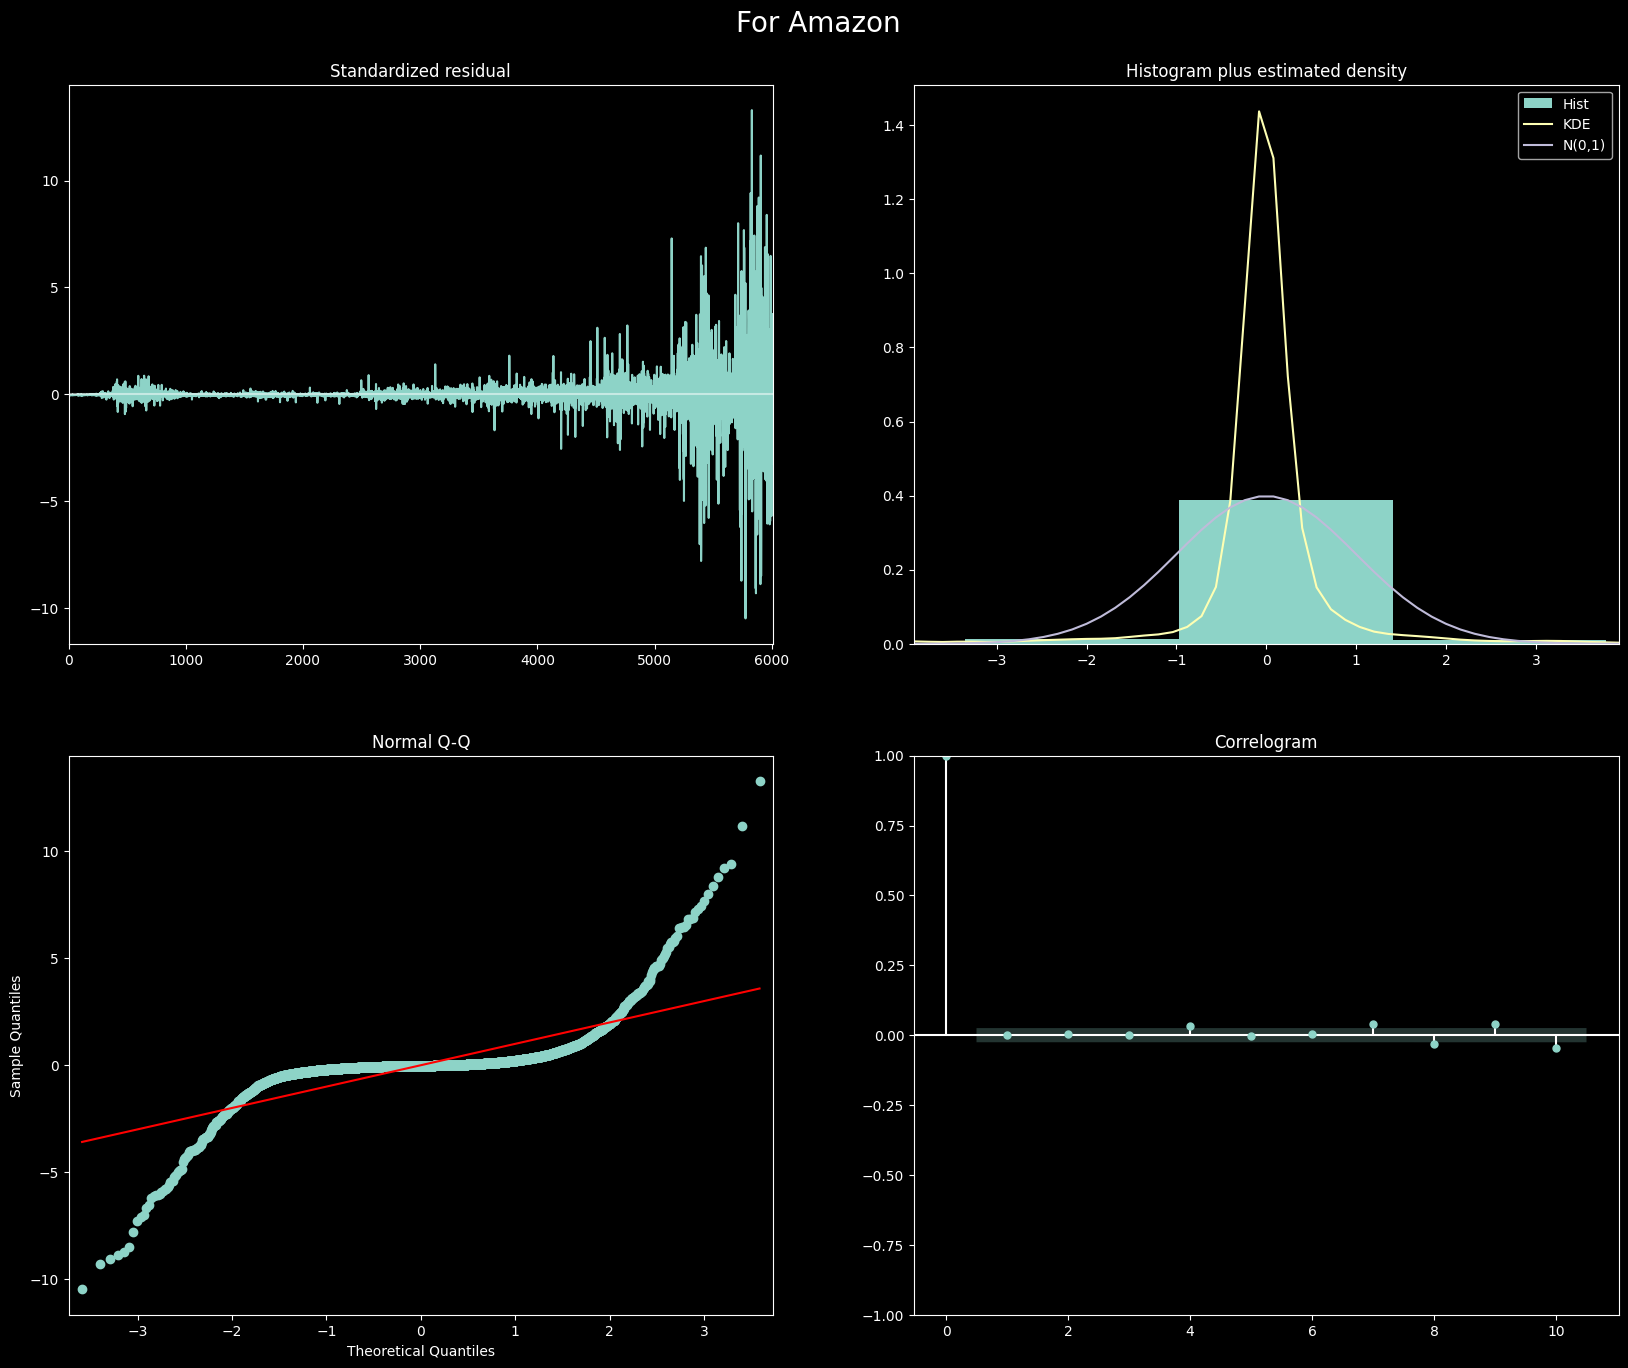

In [33]:
def display_model_plots(model, company):
    plt.style.use('dark_background')
    model.plot_diagnostics(figsize = (20, 15));
    plt.suptitle('For {}'.format(company), fontsize = 20)
    plt.subplots_adjust(top = 0.93)
    plt.show()
    plt.style.use('default')

display_model_plots(amzn_arima_model, 'Amazon')

In [34]:
def check_model_params(model, company):
    print('The best parameters for {} are {}'.format(company, model))
    print('==================')

check_model_params(amzn_arima_model, 'Amazon')

The best parameters for Amazon are  ARIMA(2,0,0)(2,1,1)[3] intercept


In [35]:
def make_predictions_and_print_rmse(model, test_data, company):
    print('=========For {}========='.format(company))

    forecast, confidence_interval = model.predict(X = test_data, n_periods = len(test_data), return_conf_int = True)
    forecast = pd.Series(forecast, index = test_data[:len(test_data)].index)
    lower = pd.Series(confidence_interval[:, 0], index = test_data[:len(test_data)].index)
    upper = pd.Series(confidence_interval[:, 1], index = test_data[:len(test_data)].index)

    rmse = np.sqrt(np.mean((forecast - test_data) ** 2))

    print('The RMSE is {}'.format(rmse))

    return forecast, lower, upper

forecast_amzn, lower_amzn, upper_amzn = make_predictions_and_print_rmse(amzn_arima_model, amzn_test, 'Amazon')

=========For Amazon=========
The RMSE is 28.095429295645758


In [37]:
def create_df_for_plotting(dataframe, forecast, lower, upper):
    data = {'Date': (dataframe['Date'])[int(len(dataframe) * 0.95):],
            'Predictions': forecast,
            'Lower_conf': lower,
            'Upper_conf': upper}

    plot_df = pd.DataFrame(data)

    return plot_df
amzn_plot_df = create_df_for_plotting(new_amzn_df, forecast_amzn, lower_amzn, upper_amzn)

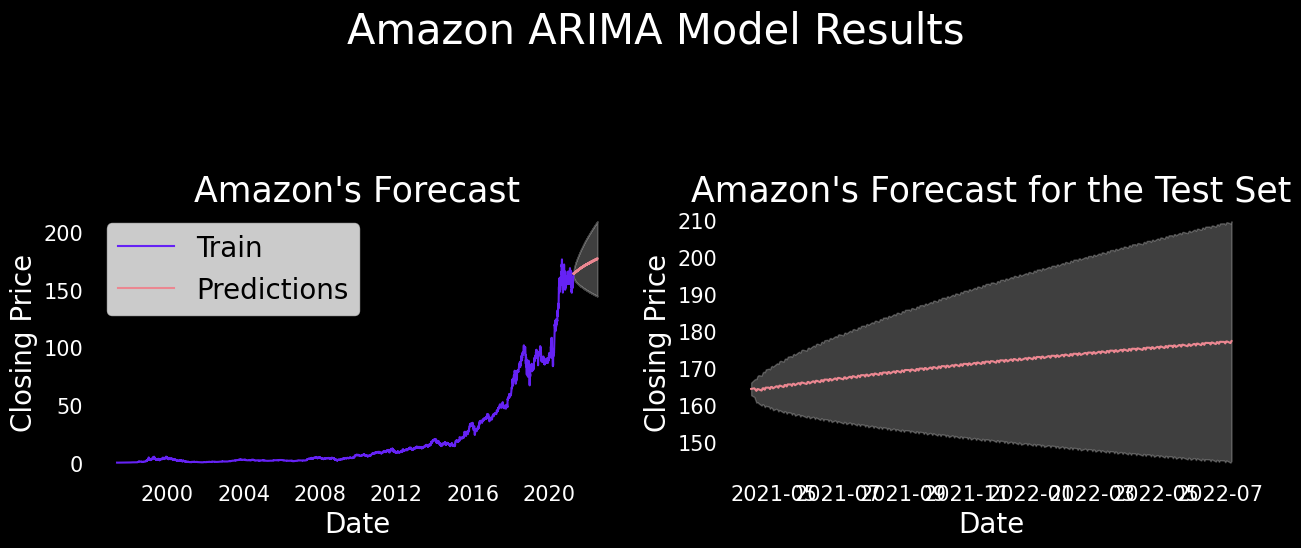

In [40]:
def show_arima_results(company_df, train_data, plot_df, forecast_data, time, feature):
    plt.figure(figsize=(15, 20), facecolor='black')
    plt.suptitle(f'{company_df.name} ARIMA Model Results', fontsize=30, color='white')

    plt.subplot(5, 2, 1, facecolor='black')
    plt.plot(time[:int(len(time) * 0.95)], train_data, color='#6522F5', label='Train')
    plt.plot(time[int(len(time) * 0.95):], plot_df['Predictions'], color='#EB8791', label='Predictions')
    plt.fill_between(plot_df['Date'].values, plot_df['Lower_conf'], plot_df['Upper_conf'], color='w', alpha=0.25)
    plt.title(f'{company_df.name}\'s Forecast', fontsize=25, color='white')
    plt.xlabel('Date', fontsize=20, color='white')
    plt.ylabel('Closing Price', fontsize=20, color='white')
    plt.xticks(fontsize=15, color='white')
    plt.yticks(fontsize=15, color='white')
    plt.legend(loc='upper left', fontsize=20)

    plt.subplot(5, 2, 2, facecolor='black')
    plt.plot(time[int(len(time) * 0.95):], forecast_data, color='#EB8791')
    plt.fill_between(plot_df['Date'].values, plot_df['Lower_conf'], plot_df['Upper_conf'], color='w', alpha=0.25)
    plt.title(f'{company_df.name}\'s Forecast for the Test Set', fontsize=25, color='white')
    plt.xlabel('Date', fontsize=20, color='white')
    plt.ylabel('Closing Price', fontsize=20, color='white')
    plt.xticks(fontsize=15, color='white')
    plt.yticks(fontsize=15, color='white')

# Assuming new_amzn_df has a 'name' attribute for the company name
new_amzn_df.name = 'Amazon'
show_arima_results(new_amzn_df, amzn_train, amzn_plot_df, forecast_amzn, new_amzn_df['Date'], 'Close')
